- These codes are adapted from the hate speech detection from Rorick in VU.

- Google colab is recommended to run the experiment due to computing power requirement of this experiment. 
- The variable 'dir' should be set as the path which you upload the training data in your google drive.

In [ ]:
!pip install transformers==4.24.0
!pip install simpletransformers==0.63.11

In [ ]:
import pandas as pd, numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [ ]:

# from google.colab import drive
# drive.mount('/content/drive')

# Make sure these paths are correct for you!!
dir = '../datasets/chatgptdata/train_data'  

train_df = pd.read_csv(f'{dir}/train.tsv', sep='\t',header = None)
dev_df = pd.read_csv(f'{dir}/dev.tsv', sep='\t', header = None)
test_df = pd.read_csv(f'{dir}/all2test.tsv', sep='\t', header = None)

full_train_df = pd.read_csv(f'{dir}/all2train.tsv',sep='\t', header = None)

save_dir = f'{dir}/outputs/'

model_name = "bert-base-uncased"

Mounted at /content/drive


In [ ]:
# hyperparameter tuning
# run this cell and after its done the next cell. This will take a while (15-30 minutes)
learning_rates = [2e-5, 3e-5, 4e-5]


for lr in learning_rates:
    model_args = {
      'max_seq_length': 64,
      'train_batch_size': 8,
      'eval_batch_size': 8,
      'num_train_epochs': 5,
      'learning_rate': lr,
      'adam_epsilon': 1e-8,
      'output_dir': f'{save_dir}/temp_{model_name}_model_{lr}',
      'overwrite_output_dir': True,
      'manual_seed': 123,
      'use_early_stopping': True,
      'evaluate_during_training': True,
      'evaluate_during_training_verbose': True,
      'save_model_every_epoch': False,
      'save_steps': -1
    }
    # Train the model
    model = ClassificationModel("bert", model_name, num_labels = 10, args=model_args, use_cuda=True)
    model.train_model(train_df, eval_df=dev_df)

    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(dev_df)


In [ ]:
# pick best performing model for final training (highest MCC score)
full_results = pd.DataFrame()
for lr in [2e-5, 3e-5, 4e-5]:
    partial_result = pd.read_csv(f'{save_dir}/temp_{model_name}_model_{lr}/training_progress_scores.csv')
    partial_result = partial_result[partial_result.global_step != 2000]
    partial_result['Learning Rate'] = str(lr)
    partial_result['Epochs'] = np.arange(len(partial_result))
    full_results = pd.concat([full_results, partial_result])

full_results.reset_index(inplace=True)

sns.set_theme(style="darkgrid")
# Plot the f-score per epoch for the different number of hidden nodes
sns.relplot(x="Epochs", y="mcc", data=full_results, hue='Learning Rate',
            ci=None, marker='o', palette='bright', kind="line"
            )

In [ ]:
# set correct parameters based on highest perfomring model above (set #epochs and learning rate)
lr = 3e-5
model_args = {
      'max_seq_length': 64,
      'train_batch_size': 8,
      'eval_batch_size': 8,
      'num_train_epochs': 3,  # <------------- SET THIS CORRECTLY
      'learning_rate': 3e-5,  # <------------- SET THIS CORRECTLY
      'adam_epsilon': 1e-8,
      'output_dir': f'{save_dir}/final_{model_name}_model_{lr}',
      'overwrite_output_dir': True,
      'manual_seed': 123,
    }
# Train the model
model = ClassificationModel("bert", model_name, num_labels = 10, args=model_args, use_cuda=True)
model.train_model(full_train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df)

# Make predictions with the model
predictions, raw_outputs = model.predict(list(test_df[0]))
print(classification_report(test_df[1], predictions))

In [ ]:
df_predictions = pd.DataFrame({
    'utterance':test_df[0],
    'gold':test_df[1],
    'predictions':predictions
})
df_predictions.to_csv(f'{save_dir}/final_{model_name}_model_{lr}/predictions.csv',
          sep= '\t')

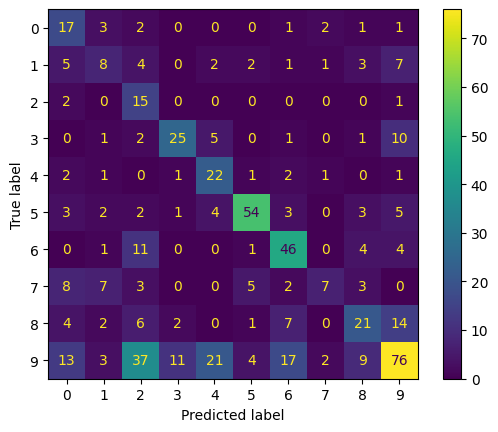

In [ ]:
confusion = confusion_matrix(test_df[1], predictions)
checklabel = [0,1,2,3,4,5,6,7,8,9]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=checklabel)
disp.plot()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
df_pred_labels = pd.DataFrame(predictions,columns=[0])
df_pred_labels.value_counts().plot(kind='bar')
# df_labels.value_counts().plot(kind='pie')